# **Obtención de los datos**



In [1]:
datos ='https://datos.cdmx.gob.mx/dataset/19e094a0-f1c0-4544-bac6-dd1d5cb8a4de/resource/d683ec6e-171a-4825-a523-2cdbf30f9894/download/defunciones_corte_110322.csv'

In [2]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_bar, geom_boxplot, geom_hline, facet_grid, labs, geom_point, geom_col, stat_count, geom_histogram, stat_density, coord_flip, geom_line, geom_count, geom_dotplot
from plotnine import scale_x_continuous, scale_y_continuous, scale_colour_discrete, scale_x_reverse, scale_y_reverse, scale_color_manual, scale_color_brewer, scale_x_discrete, scale_fill_manual
from plotnine import theme_xkcd, theme_classic, theme_light, theme, element_blank, theme_minimal
from plotnine import geom_text, position_stack, element_text
import plotnine
import sklearn.cluster as cluster
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import sklearn
import matplotlib

In [3]:
!python --version

Python 3.7.13


In [4]:
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
print(matplotlib.__version__)
print(plotnine.__version__)

1.3.5
1.21.6
1.0.2
3.2.2
0.6.0


In [5]:
df_defunciones = pd.read_csv(datos)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df_defunciones.head()

,edad,sexo,fec_defuncion,estado,causa,causa_registro,alcaldia,LugarMuerte,num_consecutivo
0,62.0,Hombre,2022-02-28,CIUDAD DE MEXICO,Covid-19 Confirmado o Sospecha,"CHOQUE SEPTICO, NEUMONIA POR SARS- COV 2, DIAB...",GUSTAVO A MADERO,Hospital,506561
1,74.0,Hombre,2022-02-28,PUEBLA,Otra,TRAUMATISMO CRANEO ENCEFALICO Y TORACICO,NaN,Hospital,506560
2,72.0,Mujer,2022-02-28,CIUDAD DE MEXICO,Otra,FALLA ORGANICA MULTIPLE CHOQUE SEPTICO ABDOMIN...,TLALPAN,Hospital,506559
3,75.0,Hombre,2022-02-28,CIUDAD DE MEXICO,Otra,"SINDROME UREMICO, INSUFICIENCIA RENAL CRONICA,...",BENITO JUAREZ,Domicilio,506558
4,73.0,Mujer,2022-02-28,ESTADO DE MEXICO,Otra,"CHOQUE SEPTICO, NEUMONIA ADQUIRIDA EN LA COMUN...",NaN,Hospital,506557


In [7]:
df_defunciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506561 entries, 0 to 506560
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   edad             506377 non-null  float64
 1   sexo             506561 non-null  object 
 2   fec_defuncion    506561 non-null  object 
 3   estado           498910 non-null  object 
 4   causa            506561 non-null  object 
 5   causa_registro   277032 non-null  object 
 6   alcaldia         342745 non-null  object 
 7   LugarMuerte      277043 non-null  object 
 8   num_consecutivo  506561 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 34.8+ MB


# **Manipulación de los datos**

Filtramos los datos para sólo incluir las defunciones en la Ciudad de México

In [8]:
df_defunciones_cdmx = df_defunciones[df_defunciones.estado == 'CIUDAD DE MEXICO' ] 

Pasamos el formato de las fechas de string a DateTime

In [9]:
df_defunciones_cdmx['fec_defuncion'] = pd.to_datetime(df_defunciones_cdmx['fec_defuncion'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Filtramos las defunciones para sólo incluir aquellas antes del inicio del esquema de vacunación (24 diciembre del 2020)

In [10]:
mask = (df_defunciones_cdmx['fec_defuncion'] > '2020-03-01') & (df_defunciones_cdmx['fec_defuncion'] <= '2020-12-24')

In [11]:
df_defunciones_prevacunacion = df_defunciones_cdmx.loc[mask]
df_defunciones_prevacunacion.tail()

,edad,sexo,fec_defuncion,estado,causa,causa_registro,alcaldia,LugarMuerte,num_consecutivo
262462,70.0,Mujer,2020-03-02,CIUDAD DE MEXICO,Otra,"CHOQUE CARDIOGENICO, LINFOMA NO HODGKIN, EVENT...",CUAUHTEMOC,Otros,244099
262464,70.0,Mujer,2020-03-02,CIUDAD DE MEXICO,Otra,"NEUMONIA ADQUIRIDA EN LA COMUNIDAD, INSUFICIEN...",BENITO JUAREZ,Otros,244097
262465,105.0,Mujer,2020-03-02,CIUDAD DE MEXICO,Otra,"INSUFICIENCIA RESPIRATORIA AGUDA, BRONCONEUMON...",VENUSTIANO CARRANZA,Otros,244096
262467,55.0,Hombre,2020-03-02,CIUDAD DE MEXICO,Otra,"INFARTO AGUDO AL MIOCARDIO, SINDROME INMUNODEF...",VENUSTIANO CARRANZA,Otros,244094
262468,34.0,Hombre,2020-03-02,CIUDAD DE MEXICO,Otra,HERIDAS PRODUCIDAS POR PROYECTILES DE ARMA DE ...,AZCAPOTZALCO,Otros,244093


In [12]:
df_defunciones_prevacunacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85904 entries, 149941 to 262468
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   edad             85893 non-null  float64       
 1   sexo             85904 non-null  object        
 2   fec_defuncion    85904 non-null  datetime64[ns]
 3   estado           85904 non-null  object        
 4   causa            85904 non-null  object        
 5   causa_registro   85895 non-null  object        
 6   alcaldia         85546 non-null  object        
 7   LugarMuerte      85904 non-null  object        
 8   num_consecutivo  85904 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 6.6+ MB


Llenamos los valores nulos con un string que diga "Sin dato"

In [13]:
df_defunciones_prevacunacion.fillna('Sin dato', inplace=True)
df_defunciones_prevacunacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85904 entries, 149941 to 262468
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   edad             85904 non-null  object        
 1   sexo             85904 non-null  object        
 2   fec_defuncion    85904 non-null  datetime64[ns]
 3   estado           85904 non-null  object        
 4   causa            85904 non-null  object        
 5   causa_registro   85904 non-null  object        
 6   alcaldia         85904 non-null  object        
 7   LugarMuerte      85904 non-null  object        
 8   num_consecutivo  85904 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 6.6+ MB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Revisamos las causas de muerte de cada caso para determinar si fue COVID-19. Utilizamos palabras clave para ello (SARS, COV, 19, NEUMONIA ATIPICA, etc.)

In [14]:
dict_causas ={}

In [15]:
for index, row in df_defunciones_prevacunacion.iterrows():
  for causa in row['causa_registro'].split(','):
    causa=causa.strip()
    if causa in dict_causas.keys():
      if 'COVID' in causa or 'SARS' in causa or 'COV' in causa or '19' in causa or 'INSUFICIENCIA RESPIRATORIA AGUDA' in causa or 'NEUMONIA ATIPICA' in causa: 
          dict_causas['COVID'] += 1
          break
      else:
          dict_causas[causa] += 1
    else:
      if ('COVID' in causa or 'SARS' in causa or 'COV' in causa or '19' in causa or 'INSUFICIENCIA RESPIRATORIA AGUDA' in causa or 'NEUMONIA ATIPICA' in causa) and not 'COVID' in dict_causas.keys() :  
          dict_causas['COVID'] = 1
          break
      else:
          dict_causas[causa] = 1

      
dict_causas['COVID']

27253

In [16]:
def detectarCOVID(row):
    bandera_covid = False
    for causa in row['causa_registro'].split(','):
      causa=causa.strip()
      if causa in dict_causas.keys():
        if 'COVID' in causa or 'SARS' in causa or 'COV' in causa or '19' in causa or 'INSUFICIENCIA RESPIRATORIA AGUDA' in causa or 'NEUMONIA ATIPICA' in causa or 'RESPIRATORIA' in causa: 
            bandera_covid = True
      else:
        if ('COVID' in causa or 'SARS' in causa or 'COV' in causa or '19' in causa or 'INSUFICIENCIA RESPIRATORIA AGUDA' in causa or 'NEUMONIA ATIPICA' in causa or 'RESPIRATORIA' in causa ) and not 'COVID' in dict_causas.keys() :  
            bandera_covid = True
    return 'COVID' if bandera_covid else 'Otra'

Utilizamos la función previa que detecta si el paciente murió a causa del COVID-19 para agregar una nueva columna a nuestro DataFrame. Nos deshacemos de la columna de num_consecutivo y estado ya que no las consideramos relevantes para nuestro caso.

In [17]:
df_defunciones_prevacunacion['causa_defuncion'] = df_defunciones_prevacunacion.apply(detectarCOVID, axis=1)
df_defunciones_prevacunacion = df_defunciones_prevacunacion.drop(['num_consecutivo', 'estado'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_defunciones_prevacunacion.head()

,edad,sexo,fec_defuncion,causa,causa_registro,alcaldia,LugarMuerte,causa_defuncion
149941,80.0,Hombre,2020-12-24,Otra,"ACIDOSIS METABOLICA, CHOQUE SEPTICO, VOLVULO, ...",GUSTAVO A MADERO,Hospital,Otra
149942,68.0,Hombre,2020-12-24,Otra,"INSUFICIENCIA CARDIACA AGUDA, ENFERMEDAD PULMO...",TLALPAN,Domicilio,Otra
149943,75.0,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,"INSUFICIENCIA RESPIRATORIA AGUDA, NEUMONIA ATI...",BENITO JUAREZ,Hospital,COVID
149944,79.0,Hombre,2020-12-24,Otra,"SINDROME UREMICO, INSUFICIENCIA RENAL CRONICA,...",AZCAPOTZALCO,Domicilio,Otra
149945,85.0,Mujer,2020-12-24,Otra,"ACIDOSIS METABOLICA, EVENTO VASCULAR CEREBRAL ...",IZTAPALAPA,Domicilio,Otra


Comparamos la discrepancia entre las muertes reportadas por COVID-19 y las muertes que consideramos "reales". Nos damos cuenta que no reportaron todas las muertes relacionadas al COVID. Tenemos una diferencia de aproximadamente 6 mil defunciones.

In [19]:
df_defunciones_prevacunacion.groupby('causa')['causa'].count().sort_values(ascending=False)

causa
Otra                              58894
Covid-19 Confirmado o Sospecha    27010
Name: causa, dtype: int64

In [20]:
df_defunciones_prevacunacion.groupby('causa_defuncion')['causa_defuncion'].count().sort_values(ascending=False)

causa_defuncion
Otra     52536
COVID    33368
Name: causa_defuncion, dtype: int64

Visualizamos las causas de muerte relacionadas al COVID. **CHECAR**

In [21]:
serie_causa = pd.Series(dict_causas)
serie_causa

ACIDOSIS METABOLICA                                                          4226
CHOQUE SEPTICO                                                               6750
VOLVULO                                                                         1
ENFERMEDAD RENAL CRONICA                                                     1493
CARDIOPATIA ISQUEMICA.                                                        237
                                                                             ... 
METASTASIS MULTIPLE.                                                            1
HERIDA PROFUNDA POR INSTRUMENTO PUNZO CORTANTE                                  1
EVENTO VASCULAR CEREBRAL TIPO ISQUEMICO.                                        1
SINDROME INMUNODEFICIENCIA ADQUIRIDA                                            1
HERIDAS PRODUCIDAS POR PROYECTILES DE ARMA DE FUEGO PENETRANTES DE CRANEO       1
Length: 22430, dtype: int64

In [22]:
df_causas = pd.DataFrame(serie_causa)
df_causas.columns = [ 'defunciones']
df_causas.reset_index(inplace=True)
df_causas = df_causas.sort_values('defunciones',ascending=False)
df_causas_repetidas = df_causas.iloc[:10:]


Clasificamos las muertes por mes para facilitar la visualización de las defunciones por mes.

In [23]:
dict_defunciones_pre_covid ={'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sep':0, 'Oct':0, 'Nov':0, 'Dec':0}
dict_defunciones_pre_otras ={'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sep':0, 'Oct':0, 'Nov':0, 'Dec':0}

In [24]:
meses = []
for index, row in df_defunciones_prevacunacion.iterrows():
  mes = row['fec_defuncion'].month
  if(mes==3):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Mar']+=1
    else:
      dict_defunciones_pre_covid['Mar']+=1
    meses.append('Mar')
  elif(mes==4):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Apr']+=1
    else:
      dict_defunciones_pre_covid['Apr']+=1
    meses.append('Apr')
  elif(mes==5):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['May']+=1
    else:
      dict_defunciones_pre_covid['May']+=1
    meses.append('May')
  elif(mes==6):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Jun']+=1
    else:
      dict_defunciones_pre_covid['Jun']+=1
    meses.append('Jun')
  elif(mes==7):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Jul']+=1
    else:
      dict_defunciones_pre_covid['Jul']+=1
    meses.append('Jul')
  elif(mes==8):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Aug']+=1
    else:
      dict_defunciones_pre_covid['Aug']+=1
    meses.append('Aug')
  elif(mes==9):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Sep']+=1
    else:
      dict_defunciones_pre_covid['Sep']+=1
    meses.append('Sep')
  elif(mes==10):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Oct']+=1
    else:
      dict_defunciones_pre_covid['Oct']+=1
    meses.append('Oct')
  elif(mes==11):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Nov']+=1
    else:
      dict_defunciones_pre_covid['Nov']+=1
    meses.append('Nov')
  elif(mes==12):
    if('Otra' in row['causa']):
      dict_defunciones_pre_otras['Dec']+=1
    else:
      dict_defunciones_pre_covid['Dec']+=1
    meses.append('Dec')

In [25]:
df_defunciones_prevacunacion['Mes']=meses

In [26]:
df_defunciones_prevacunacion

,edad,sexo,fec_defuncion,causa,causa_registro,alcaldia,LugarMuerte,causa_defuncion,Mes
149941,80.0,Hombre,2020-12-24,Otra,"ACIDOSIS METABOLICA, CHOQUE SEPTICO, VOLVULO, ...",GUSTAVO A MADERO,Hospital,Otra,Dec
149942,68.0,Hombre,2020-12-24,Otra,"INSUFICIENCIA CARDIACA AGUDA, ENFERMEDAD PULMO...",TLALPAN,Domicilio,Otra,Dec
149943,75.0,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,"INSUFICIENCIA RESPIRATORIA AGUDA, NEUMONIA ATI...",BENITO JUAREZ,Hospital,COVID,Dec
149944,79.0,Hombre,2020-12-24,Otra,"SINDROME UREMICO, INSUFICIENCIA RENAL CRONICA,...",AZCAPOTZALCO,Domicilio,Otra,Dec
149945,85.0,Mujer,2020-12-24,Otra,"ACIDOSIS METABOLICA, EVENTO VASCULAR CEREBRAL ...",IZTAPALAPA,Domicilio,Otra,Dec
...,...,...,...,...,...,...,...,...,...
262462,70.0,Mujer,2020-03-02,Otra,"CHOQUE CARDIOGENICO, LINFOMA NO HODGKIN, EVENT...",CUAUHTEMOC,Otros,Otra,Mar
262464,70.0,Mujer,2020-03-02,Otra,"NEUMONIA ADQUIRIDA EN LA COMUNIDAD, INSUFICIEN...",BENITO JUAREZ,Otros,Otra,Mar
262465,105.0,Mujer,2020-03-02,Otra,"INSUFICIENCIA RESPIRATORIA AGUDA, BRONCONEUMON...",VENUSTIANO CARRANZA,Otros,COVID,Mar
262467,55.0,Hombre,2020-03-02,Otra,"INFARTO AGUDO AL MIOCARDIO, SINDROME INMUNODEF...",VENUSTIANO CARRANZA,Otros,Otra,Mar


# **Visualización de datos**

Clasificamos las muertes por mes dependiendo de su causa. La línea azul representa las defunciones por COVID y la roja por otras causas.

In [27]:
df_meses_defunciones=pd.DataFrame({'covid':dict_defunciones_pre_covid, 'otras':dict_defunciones_pre_otras})
df_meses_defunciones = df_meses_defunciones.reset_index(level=0)
df_meses_defunciones.columns = ['Mes', 'Covid','Otras']
df_meses_defunciones

,Mes,Covid,Otras
0,Mar,11,4989
1,Apr,1561,5779
2,May,5867,8812
3,Jun,3961,6436
4,Jul,2355,5430
5,Aug,1942,5428
6,Sep,1831,5107
7,Oct,1978,5481
8,Nov,2905,5786
9,Dec,4599,5646


In [28]:
#df_meses_defunciones = pd.melt(df_meses_defunciones, id_vars=['Mes'], ignore_index=True, value_name='Defunciones')
#df_meses_defunciones['value'] = df_meses_defunciones['value'].astype(int)
#df_meses_defunciones
#El melt no sirvio para graficar

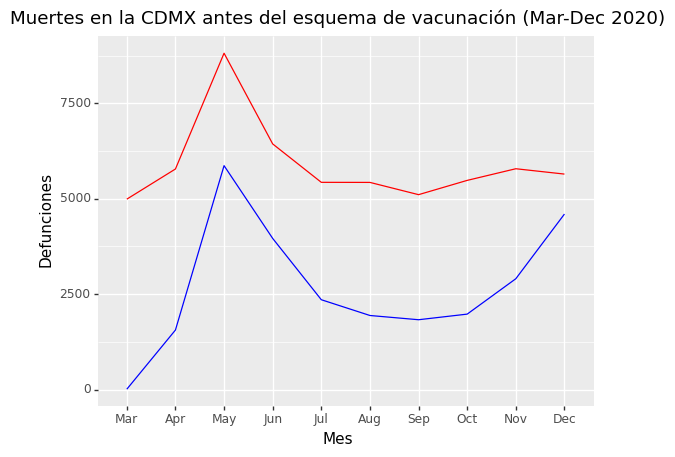

<ggplot: (8733549977233)>

In [29]:
meses=['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ggplot(df_meses_defunciones, aes(x="Mes")) + geom_line(aes(y='Covid', group=1), color='blue') + geom_line(aes(y='Otras', group=1), color='red') + scale_x_discrete(limits=meses) + labs(x="Mes",  
                                                                           y="Defunciones", 
                                                                           title="Muertes en la CDMX antes del esquema de vacunación (Mar-Dec 2020)")

Filtramos las defunciones para sólo mostrar las que fueron por COVID según nuestro criterio, no por el registro oficial.

In [30]:
df_defuncion_covid = df_defunciones_prevacunacion.loc[(df_defunciones_prevacunacion['causa_defuncion'] == 'COVID')]
df_defuncion_covid

,edad,sexo,fec_defuncion,causa,causa_registro,alcaldia,LugarMuerte,causa_defuncion,Mes
149943,75.0,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,"INSUFICIENCIA RESPIRATORIA AGUDA, NEUMONIA ATI...",BENITO JUAREZ,Hospital,COVID,Dec
149949,53.0,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,"CHOQUE SEPTICO, NEUMONIA VIRAL SOSPECHA SARS C...",GUSTAVO A MADERO,Hospital,COVID,Dec
149952,55.0,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,"INSUFICIENCIA RESPIRATORIA AGUDA, NEUMONIA ATI...",TLALPAN,Hospital,COVID,Dec
149958,62.0,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,"CHOQUE SEPTICO, NEUMONIA ATIPICA, PROBABLE INF...",VENUSTIANO CARRANZA,Hospital,COVID,Dec
149961,86.0,Mujer,2020-12-24,Otra,"INSUFICIENCIA RESPIRATORIA, NEUMONIA NO ESPECI...",BENITO JUAREZ,Hospital,COVID,Dec
...,...,...,...,...,...,...,...,...,...
262415,0.0,Hombre,2020-03-02,Otra,"INSUFICIENCIA RESPIRATORIA, NEUMONIA HEMORRAGI...",GUSTAVO A MADERO,Hospital,COVID,Mar
262416,92.0,Hombre,2020-03-02,Otra,"INSUFICIENCIA RESPIRATORIA, NEUMONIA ADQUIRIDA...",GUSTAVO A MADERO,Hospital,COVID,Mar
262449,0.0,Hombre,2020-03-02,Otra,"HEMORRAGIA PULMONAR, SINDROME DIFICULTAD RESPI...",CUAUHTEMOC,Hospital,COVID,Mar
262458,98.0,Mujer,2020-03-02,Otra,"ACIDOSIS RESPIRATORIA, TROMBOSIS PULMONAR, INS...",IZTACALCO,Otros,COVID,Mar


Visualizamos los lugares de muerte para personas que fallecieron a causa del COVID-19.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  PlotnineWarning)


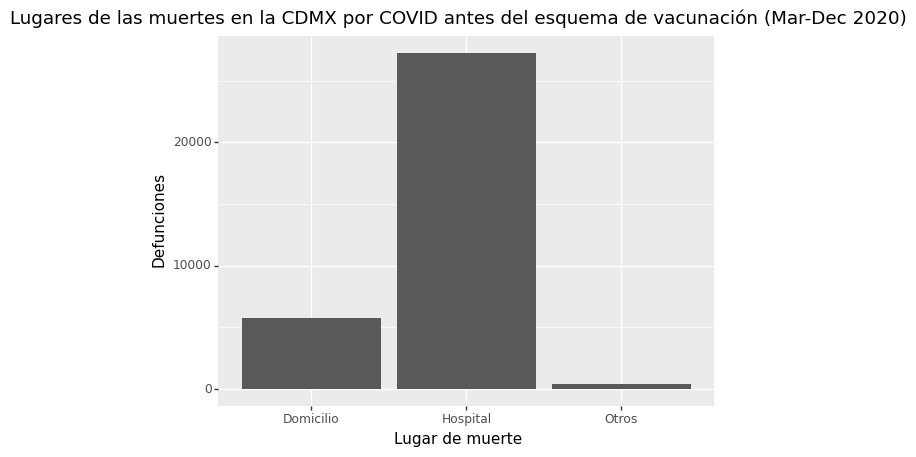

<ggplot: (8733544960101)>

In [31]:
ggplot(df_defuncion_covid) + aes(x='LugarMuerte' ) + geom_bar() + labs(x="Lugar de muerte",  
                                                                           y="Defunciones", 
                                                                           title="Lugares de las muertes en la CDMX por COVID antes del esquema de vacunación (Mar-Dec 2020)")  + scale_fill_manual(values=["#9933FF", "#33FFFF"])

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


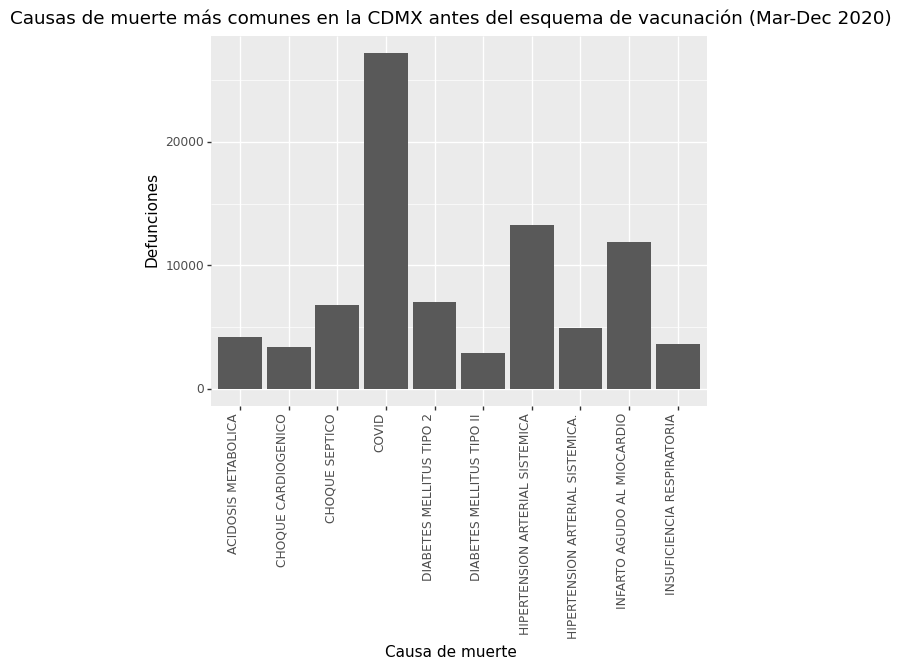

<ggplot: (8733545837861)>

In [32]:
ggplot(df_causas_repetidas) + aes(x="index", y="defunciones") +  geom_col() + theme(axis_text_x = element_text(angle=90, hjust=1)) + labs(x="Causa de muerte",  
                                                                           y="Defunciones", 
                                                                           title="Causas de muerte más comunes en la CDMX antes del esquema de vacunación (Mar-Dec 2020)")

Comparamos la cantidad de defunciones por COVID y por otras causas en nuestro periodo de tiempo.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  PlotnineWarning)


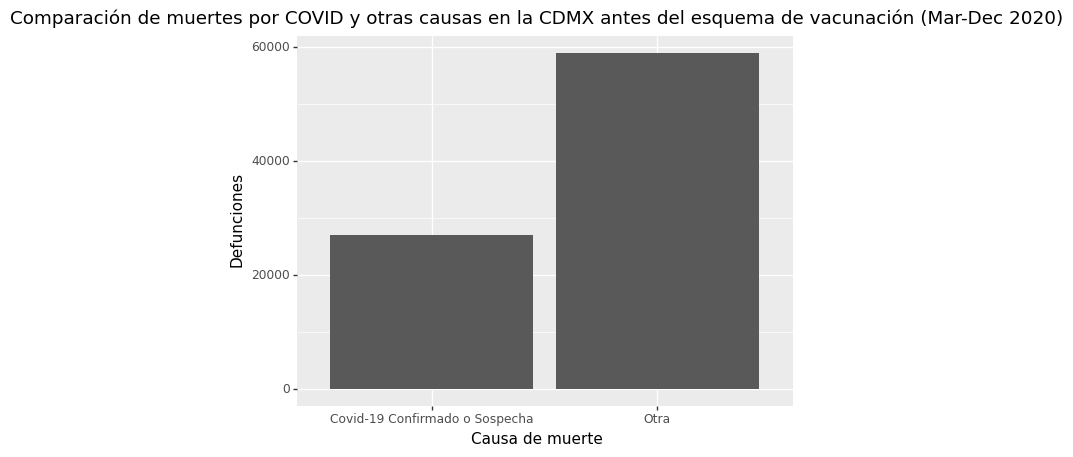

<ggplot: (8733545834505)>

In [33]:
ggplot(df_defunciones_prevacunacion) + aes(x='causa' ) + geom_bar() + labs(x="Causa de muerte",  
                                                                           y="Defunciones", 
                                                                           title="Comparación de muertes por COVID y otras causas en la CDMX antes del esquema de vacunación (Mar-Dec 2020)")  + scale_fill_manual(values=["#9933FF", "#33FFFF"])

In [34]:
df_defunciones_prevacunacion.head()

,edad,sexo,fec_defuncion,causa,causa_registro,alcaldia,LugarMuerte,causa_defuncion,Mes
149941,80.0,Hombre,2020-12-24,Otra,"ACIDOSIS METABOLICA, CHOQUE SEPTICO, VOLVULO, ...",GUSTAVO A MADERO,Hospital,Otra,Dec
149942,68.0,Hombre,2020-12-24,Otra,"INSUFICIENCIA CARDIACA AGUDA, ENFERMEDAD PULMO...",TLALPAN,Domicilio,Otra,Dec
149943,75.0,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,"INSUFICIENCIA RESPIRATORIA AGUDA, NEUMONIA ATI...",BENITO JUAREZ,Hospital,COVID,Dec
149944,79.0,Hombre,2020-12-24,Otra,"SINDROME UREMICO, INSUFICIENCIA RENAL CRONICA,...",AZCAPOTZALCO,Domicilio,Otra,Dec
149945,85.0,Mujer,2020-12-24,Otra,"ACIDOSIS METABOLICA, EVENTO VASCULAR CEREBRAL ...",IZTAPALAPA,Domicilio,Otra,Dec


Agrupamos las edades en grupos de 10 para determinar cuáles son los grupos más vulnerables.

In [35]:
dict_edad_genero = {}   

In [36]:
for index, row in df_defunciones_prevacunacion.iterrows():
  if row['edad'] == 'Sin dato':
    continue
  edad = int(row['edad'])
  if edad >= 0 and edad < 10:
    row['edad'] = "0-9"
  elif edad >= 10 and edad < 20:
    row['edad'] = "10-19"
  elif edad >= 20 and edad < 30:
    row['edad'] = "20-29"
  elif edad >= 30 and edad < 40:
    row['edad'] = "30-39"
  elif edad >= 40 and edad < 50:
    row['edad'] = "40-49"
  elif edad >= 50 and edad < 60:
    row['edad'] = "50-59"
  elif edad >= 60 and edad < 70:
    row['edad'] = "60-69"
  elif edad >= 70 and edad < 80:
    row['edad'] = "70-79"
  elif edad >= 80 and edad < 90:
    row['edad'] = "80-89"
  elif edad >= 90 and edad < 100:
    row['edad'] = "90-99"
  elif edad >= 100 and edad < 110:
    row['edad'] = "100-109"
  elif edad >= 110 and edad < 120:
    row['edad'] = "110-119"
  dict_edad_genero[index] = {"edad": row['edad'], "sexo": row['sexo'], "fec_defuncion": row['fec_defuncion'], "causa": row['causa'], "alcaldia": row['alcaldia'], "LugarMuerte": row['LugarMuerte'], "causa_defuncion": row['causa_defuncion']}

In [37]:
df_defunciones_edad_genero = pd.DataFrame.from_dict(dict_edad_genero, "index")
df_defunciones_edad_genero.head()

,edad,sexo,fec_defuncion,causa,alcaldia,LugarMuerte,causa_defuncion
149941,80-89,Hombre,2020-12-24,Otra,GUSTAVO A MADERO,Hospital,Otra
149942,60-69,Hombre,2020-12-24,Otra,TLALPAN,Domicilio,Otra
149943,70-79,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,BENITO JUAREZ,Hospital,COVID
149944,70-79,Hombre,2020-12-24,Otra,AZCAPOTZALCO,Domicilio,Otra
149945,80-89,Mujer,2020-12-24,Otra,IZTAPALAPA,Domicilio,Otra


In [38]:
df_defunciones_edad_genero_covid = df_defunciones_edad_genero[df_defunciones_edad_genero.causa_defuncion == 'COVID']
df_defunciones_edad_genero_covid.head()

,edad,sexo,fec_defuncion,causa,alcaldia,LugarMuerte,causa_defuncion
149943,70-79,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,BENITO JUAREZ,Hospital,COVID
149949,50-59,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,GUSTAVO A MADERO,Hospital,COVID
149952,50-59,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,TLALPAN,Hospital,COVID
149958,60-69,Hombre,2020-12-24,Covid-19 Confirmado o Sospecha,VENUSTIANO CARRANZA,Hospital,COVID
149961,80-89,Mujer,2020-12-24,Otra,BENITO JUAREZ,Hospital,COVID


Graficamos las defunciones según el grupo de edad que determinamos anteriormente y su sexo.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 81'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


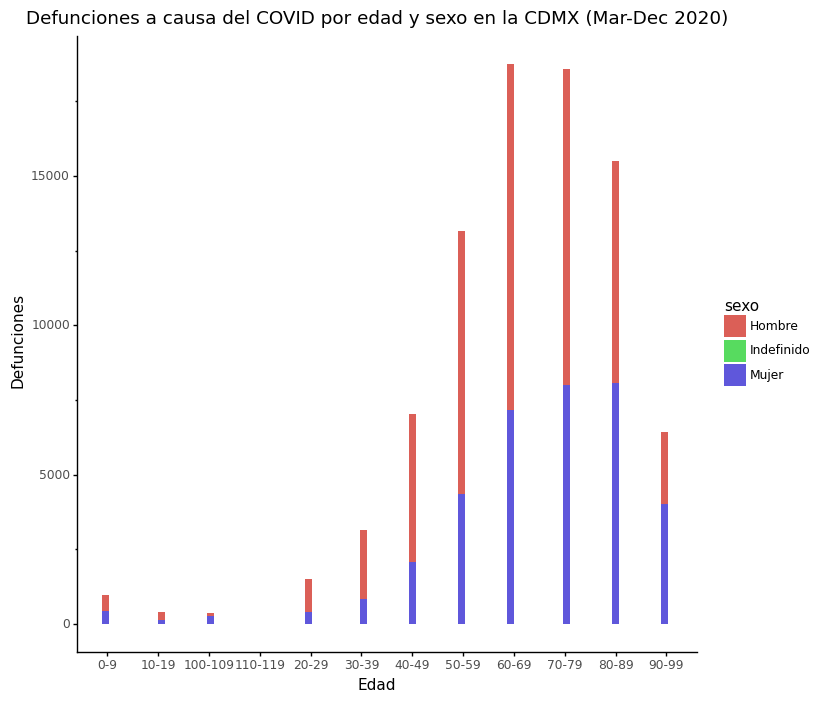

<ggplot: (8733545403205)>

In [39]:
ggplot(df_defunciones_edad_genero,aes(x = 'edad', fill='sexo' )) + geom_histogram() + labs(x="Edad", y="Defunciones",title = 'Defunciones a causa del COVID por edad y sexo en la CDMX (Mar-Dec 2020)', subtitle = 'Mar-Dec 2020')+ theme_classic() + theme(figure_size=(8, 8))

In [40]:
#Fuente: SEDECO https://www.sedeco.cdmx.gob.mx/storage/app/media/uploaded-files/resultados-del-censo-pob-y-viv-2020-1.pdf
poblacion_alcaldias = {
    'ALVARO OBREGON':759137,
    'AZCAPOTZALCO':432205,
    'BENITO JUAREZ':434153,
    'COYOACAN':614447,
    'CUAJIMALPA':217686,
    'CUAUHTEMOC':545884,
    'GUSTAVO A MADERO':1173351,
    'IZTACALCO':404695,
    'IZTAPALAPA':1835486,
    'MAGDALENA CONTRERAS':247622,
    'MIGUEL HIDALGO':414470,
    'MILPA ALTA':152685,
    'TLAHUAC':392313,
    'TLALPAN':699928,
    'VENUSTIANO CARRANZA':443704,
    'XOCHIMILCO':442178,
}

#Agrupamos por alcaldia y quitamos las columnas irrelevantes
df_defunciones_alcaldias = pd.DataFrame(df_defunciones_edad_genero_covid.groupby('alcaldia').count())
df_defunciones_alcaldias.reset_index(inplace=True)
df_defunciones_alcaldias = df_defunciones_alcaldias.drop(['sexo', 'fec_defuncion', 'causa', 'LugarMuerte', 'causa_defuncion'],axis=1)
df_defunciones_alcaldias.columns = ['alcaldia', 'defunciones']

#Dividimos las defunciones entre la poblacion de la alcaldia para normalizar
arr_aux = []
for index, row in df_defunciones_alcaldias.iterrows():
  if row['alcaldia'] != 'Sin dato':
    arr_aux.append(row['defunciones']/poblacion_alcaldias[row['alcaldia']])
  else:
    arr_aux.append(0)

#Agregamos una nueva columna para la relacion entre defunciones y poblacion
df_defunciones_alcaldias['relacion'] = arr_aux
df_defunciones_alcaldias = df_defunciones_alcaldias.sort_values(by='relacion', ascending=False)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


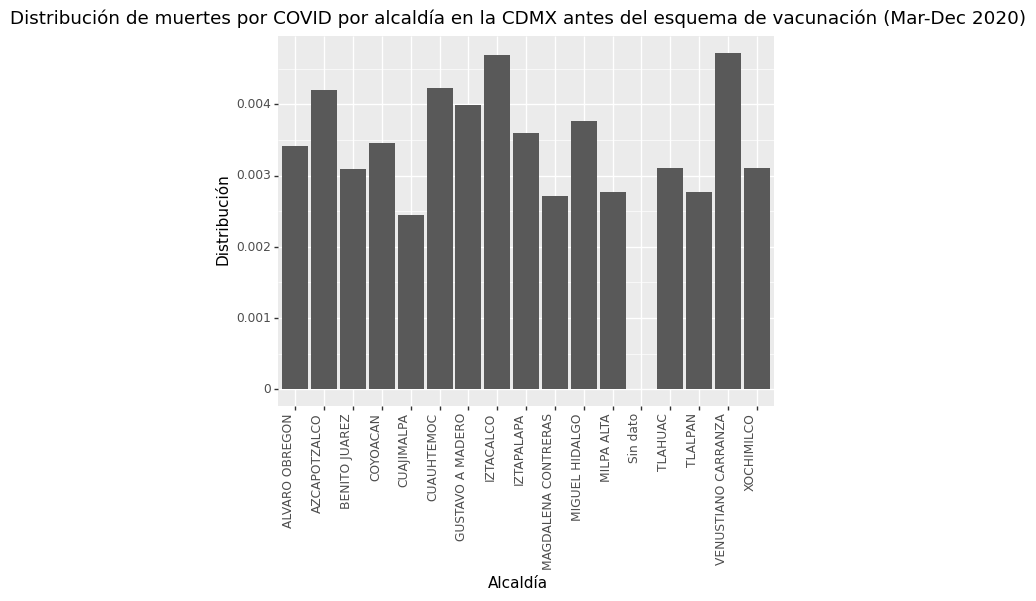

<ggplot: (8733545834705)>

In [41]:
ggplot(df_defunciones_alcaldias) + aes(x='alcaldia', y = "relacion" ) + geom_bar(stat = "identity") + labs(x="Alcaldía",  
                                                                           y="Distribución", 
                                                                           title="Distribución de muertes por COVID por alcaldía en la CDMX antes del esquema de vacunación (Mar-Dec 2020)")  + theme(axis_text_x = element_text(angle=90, hjust=1))

# **Implementación de modelo de Machine Learning**

Nos deshacemos de la columna ***Causa Registro*** debido a que será muy difícil implementar el modelo con esta variable.

In [42]:
df_defunciones_prevacunacion_sinCausa = df_defunciones_prevacunacion.drop(['causa_registro'],axis=1).astype(str)

Separamos nuestro conjunto de datos con una relación de **80%** datos de entrenamiento y **20%** de prueba.

In [43]:
X_train, X_test = train_test_split(df_defunciones_prevacunacion_sinCausa, test_size=0.2, random_state=1)
X_train_original = X_train

Realizamos al One Hot Encoding para convertir nuestro DataFrame a una matriz para clasificar las variables categóricas.

In [44]:
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)

Pasamos nuestra **Sparse Matrix** a un arreglo de numpy para poder manejarlo dentro de otros modelos.

In [45]:
X_train = X_train.toarray()

Realizamos el **Análisis de Componentes Principales(PCA)**.


In [46]:
pca = PCA(n_components = 2)

In [47]:
X_pca = pca.fit_transform(X_train)

In [48]:
print(pca.explained_variance_ratio_)

[0.18630876 0.08365759]


Reseteamos el index del DataFrame para que coincidan los índices y podamos unirlos.

In [49]:
df_defunciones_prevacunacion_sinCausa = df_defunciones_prevacunacion_sinCausa.reset_index(drop=True)

In [50]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df.columns = ["PC1", "PC2"]
X_pca_df["causa_defuncion"] = df_defunciones_prevacunacion_sinCausa.causa_defuncion

Visualizamos **PC1** y **PC2**.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


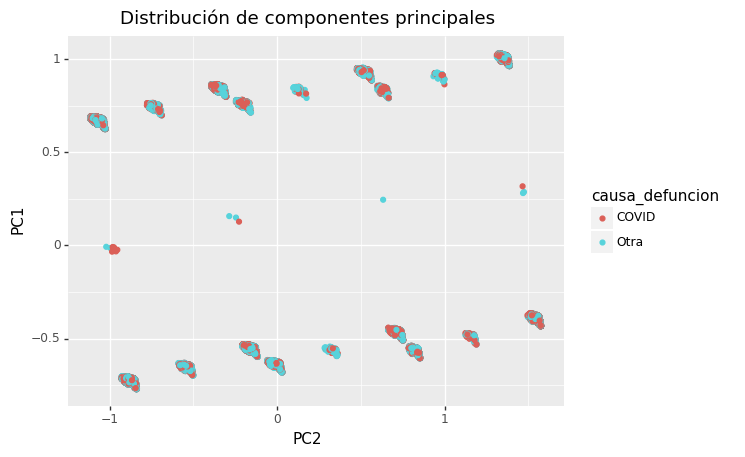

<ggplot: (8733538264837)>

In [52]:
ggplot(X_pca_df) + aes(x="PC1", y="PC2", color="causa_defuncion") + geom_point() + labs(x="PC2", y="PC1",title = 'Distribución de componentes principales')

Realizamos un **clustering**. Primero aplicamos el *método del codo* para determinar el número ideal de clusters.

In [ ]:
K = range(2,12)
wss = []

for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans = kmeans.fit(X_train)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

Text(0, 0.5, 'Suma de errores cuadrados dentro del grupo')

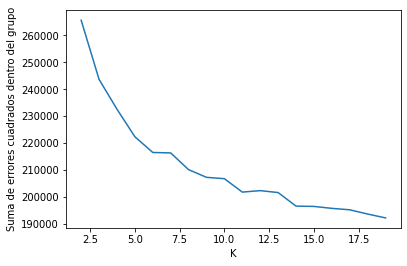

In [ ]:
plt.plot(K,wss)
plt.xlabel("K")
plt.ylabel("Suma de errores cuadrados dentro del grupo")

Mandamos nuestra matriz codificada a un Data Frame para manejarlo más fácil.

In [54]:
df_x_train = pd.DataFrame(X_train)
df_x_train.columns = onehot_encoder.get_feature_names_out()

In [ ]:
df_x_train

,edad_0.0,edad_1.0,edad_10.0,edad_100.0,edad_101.0,edad_102.0,edad_103.0,edad_104.0,edad_105.0,edad_106.0,...,Mes_Apr,Mes_Aug,Mes_Dec,Mes_Jul,Mes_Jun,Mes_Mar,Mes_May,Mes_Nov,Mes_Oct,Mes_Sep
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Llevamos a cabo el clustering con 6 clusters, que es nuestro número ideal.

In [55]:
kmeans = cluster.KMeans(n_clusters = 6)
kmeans.fit(df_x_train)
df_x_train["clusters"] = kmeans.labels_

Relacionamos nuestro conjunto de entrenamiento con los clusters obtenidos.

In [56]:
X_train_original = X_train_original.reset_index(drop=True)
X_train_original['Cluster'] = df_x_train["clusters"]

In [ ]:
X_train_original

,edad,sexo,fec_defuncion,causa,alcaldia,LugarMuerte,causa_defuncion,Mes,Cluster
0,65.0,Mujer,2020-10-25,Otra,COYOACAN,Hospital,Otra,Oct,4
1,81.0,Hombre,2020-04-14,Otra,GUSTAVO A MADERO,Domicilio,Otra,Apr,3
2,82.0,Hombre,2020-04-28,Otra,TLAHUAC,Domicilio,Otra,Apr,3
3,88.0,Mujer,2020-05-19,Otra,BENITO JUAREZ,Domicilio,Otra,May,0
4,75.0,Mujer,2020-05-28,Otra,ALVARO OBREGON,Domicilio,Otra,May,0
...,...,...,...,...,...,...,...,...,...
68718,70.0,Hombre,2020-10-21,Covid-19 Confirmado o Sospecha,ALVARO OBREGON,Hospital,COVID,Oct,5
68719,60.0,Hombre,2020-05-01,Otra,GUSTAVO A MADERO,Hospital,Otra,May,1
68720,70.0,Hombre,2020-06-25,Otra,VENUSTIANO CARRANZA,Domicilio,Otra,Jun,3
68721,54.0,Hombre,2020-12-14,Otra,IZTAPALAPA,Hospital,COVID,Dec,1


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


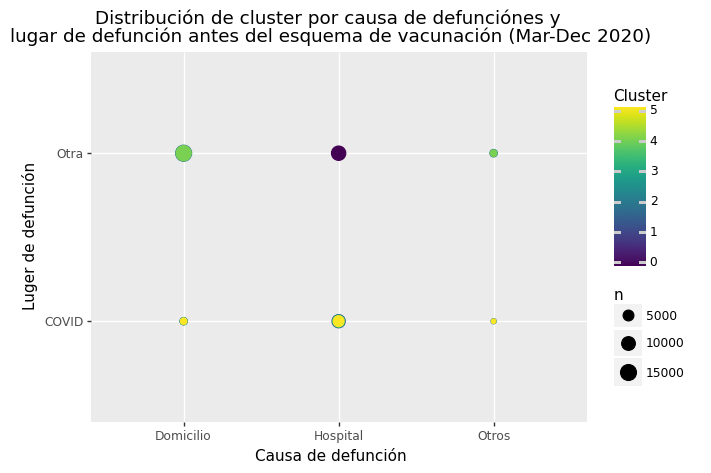

<ggplot: (8733535371253)>

In [60]:
ggplot(X_train_original) + aes(x="LugarMuerte", y="causa_defuncion", color="Cluster") + geom_count() + labs(x="Causa de defunción",  
                                                                           y="Luger de defunción", 
                                                                           title="Distribución de cluster por causa de defunciónes y \nlugar de defunción antes del esquema de vacunación (Mar-Dec 2020)")

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


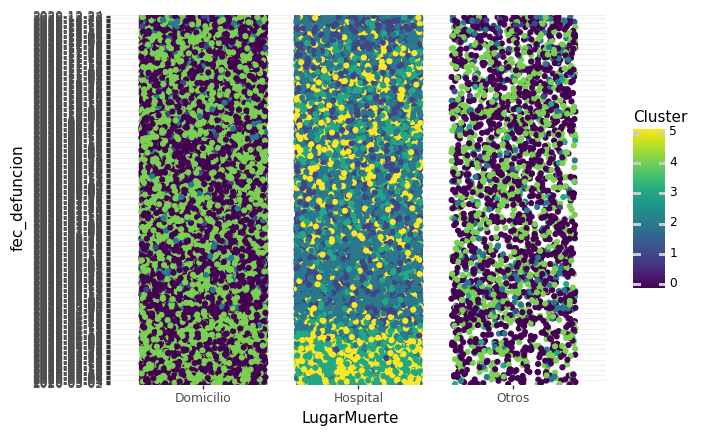

(<ggplot: (8779321151869)>,)

In [ ]:
ggplot(X_train_original) + aes(x="LugarMuerte", y="fec_defuncion", color="Cluster") + geom_jitter(),

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


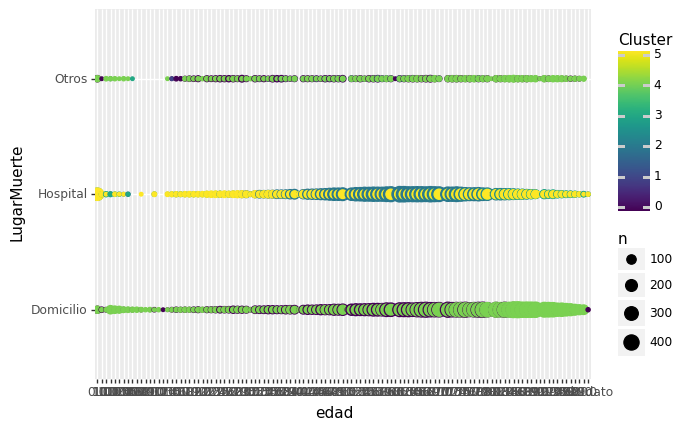

<ggplot: (8779323508913)>

In [ ]:
ggplot(X_train_original) + aes(x="edad", y="LugarMuerte", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


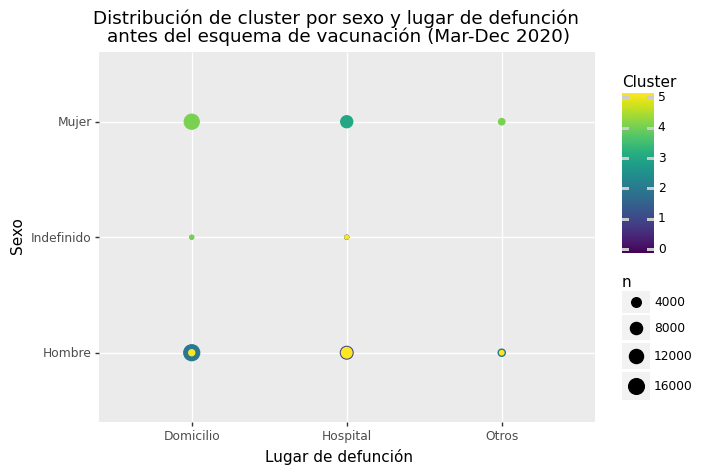

<ggplot: (8733545846265)>

In [61]:
ggplot(X_train_original) + aes(x="LugarMuerte", y="sexo", color="Cluster") + geom_count() + labs(x="Lugar de defunción",  
                                                                           y="Sexo", 
                                                                           title="Distribución de cluster por sexo y lugar de defunción \nantes del esquema de vacunación (Mar-Dec 2020)")

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


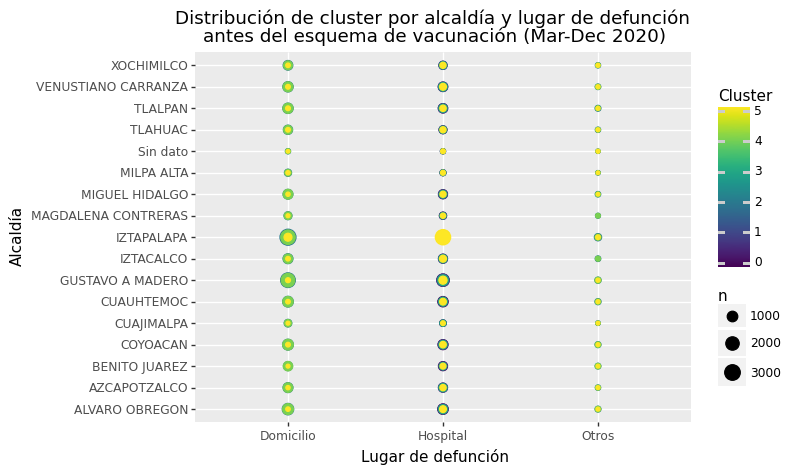

<ggplot: (8733545815713)>

In [63]:
ggplot(X_train_original) + aes(x="LugarMuerte", y="alcaldia", color="Cluster") + geom_count() + labs(x="Lugar de defunción",  
                                                                           y="Alcaldía", 
                                                                           title="Distribución de cluster por alcaldía y lugar de defunción \nantes del esquema de vacunación (Mar-Dec 2020)")

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


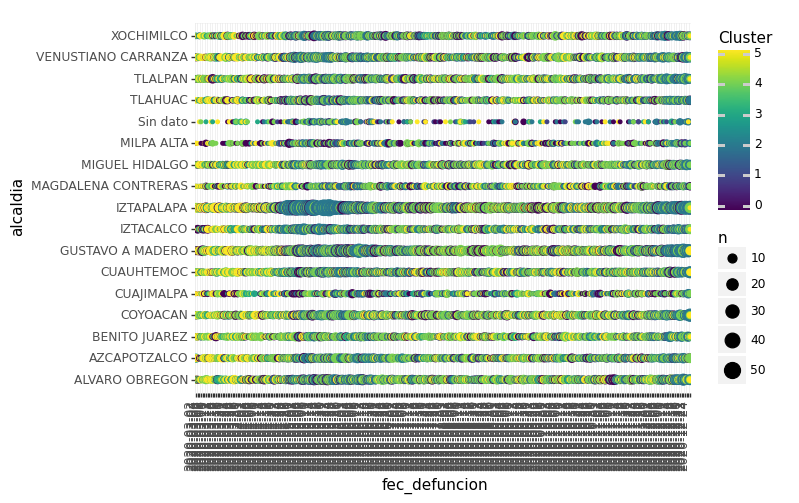

<ggplot: (8779297818165)>

In [ ]:
ggplot(X_train_original) + aes(x="fec_defuncion", y="alcaldia", color="Cluster") + geom_count() + theme(axis_text_x = element_text(angle=90, hjust=1))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


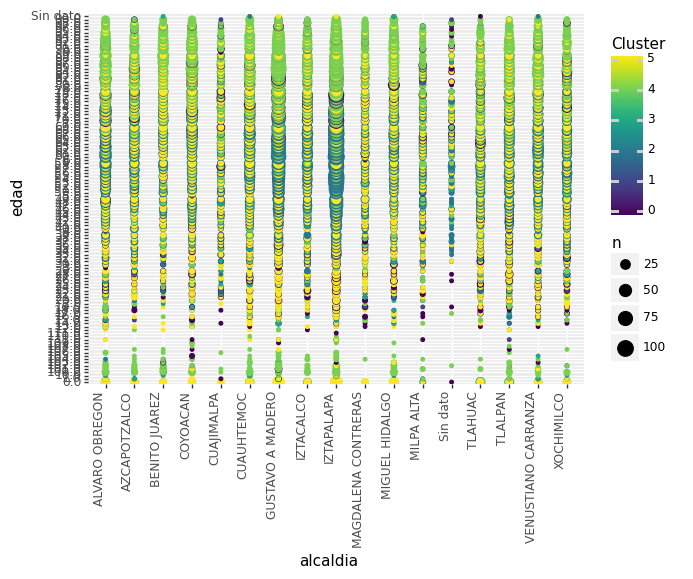

<ggplot: (8779321467037)>

In [ ]:
ggplot(X_train_original) + aes(x="edad", y="alcaldia", color="Cluster") + geom_count() + theme(axis_text_x = element_text(angle=90, hjust=1))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


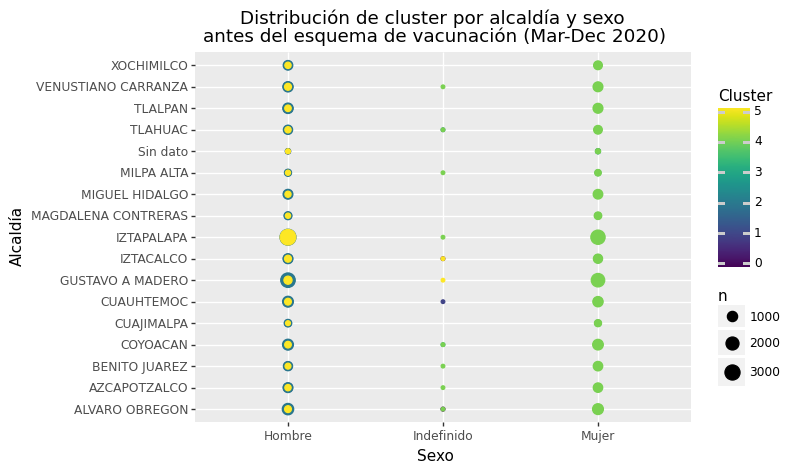

<ggplot: (8733535521089)>

In [64]:
ggplot(X_train_original) + aes(x="sexo", y="alcaldia", color="Cluster") + geom_count() + labs(x="Sexo",  
                                                                           y="Alcaldía", 
                                                                           title="Distribución de cluster por alcaldía y sexo \nantes del esquema de vacunación (Mar-Dec 2020)")

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


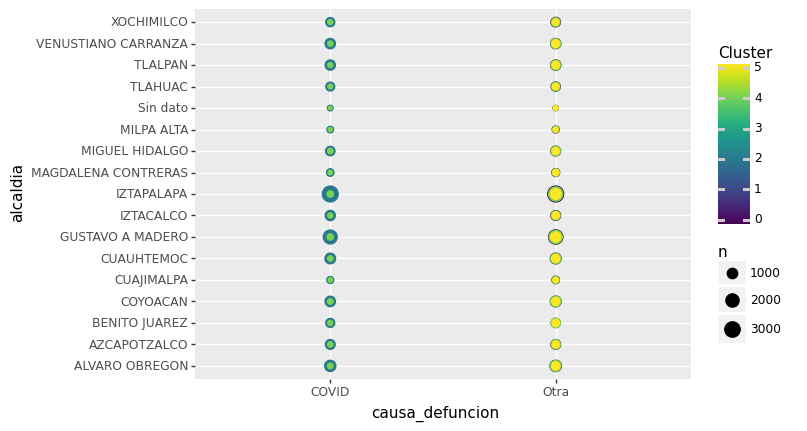

<ggplot: (8779318185617)>

In [ ]:
ggplot(X_train_original) + aes(x="causa_defuncion", y="alcaldia", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


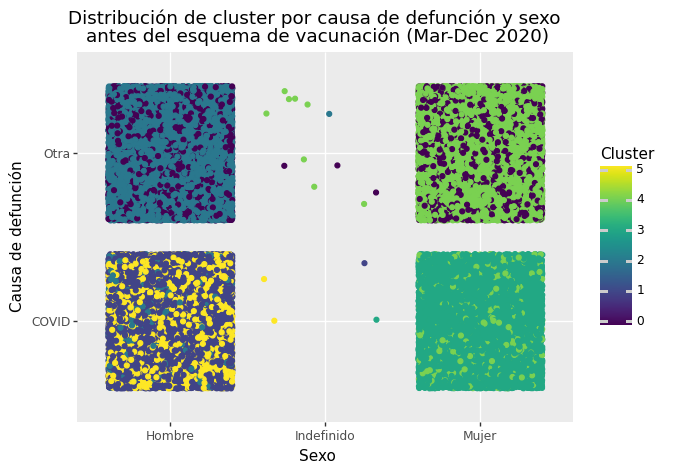

<ggplot: (8733533743449)>

In [68]:
ggplot(X_train_original) + aes(x="sexo", y="causa_defuncion", color="Cluster") + geom_jitter() + labs(x="Sexo",  
                                                                           y="Causa de defunción", 
                                                                           title="Distribución de cluster por causa de defunción y sexo \nantes del esquema de vacunación (Mar-Dec 2020)")

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


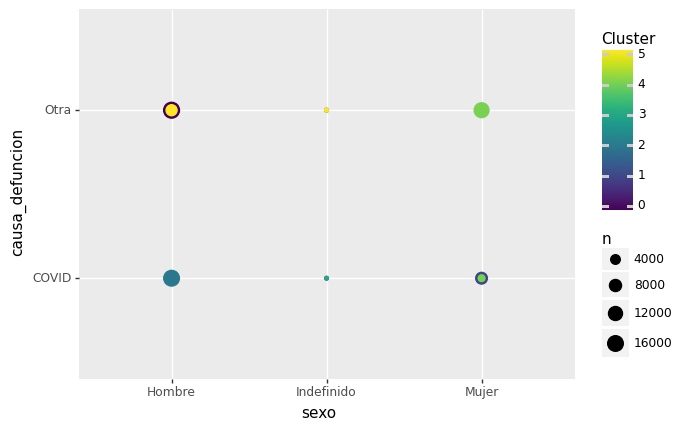

<ggplot: (8779322656361)>

In [ ]:
ggplot(X_train_original) + aes(x="sexo", y="causa_defuncion", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


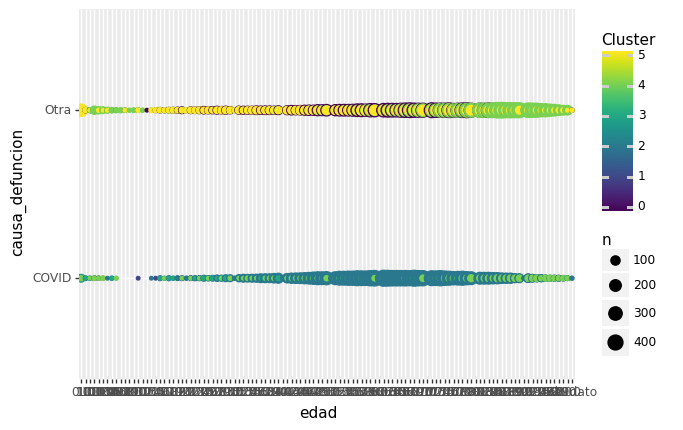

<ggplot: (8779322764841)>

In [ ]:
ggplot(X_train_original) + aes(x="edad", y="causa_defuncion", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


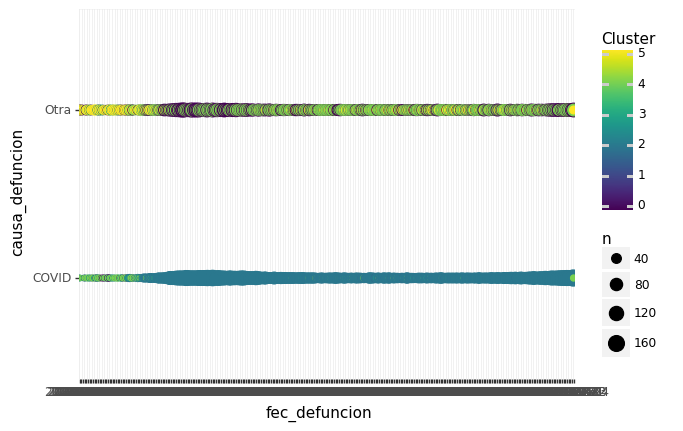

<ggplot: (8779326464673)>

In [ ]:
ggplot(X_train_original) + aes(x="fec_defuncion", y="causa_defuncion", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


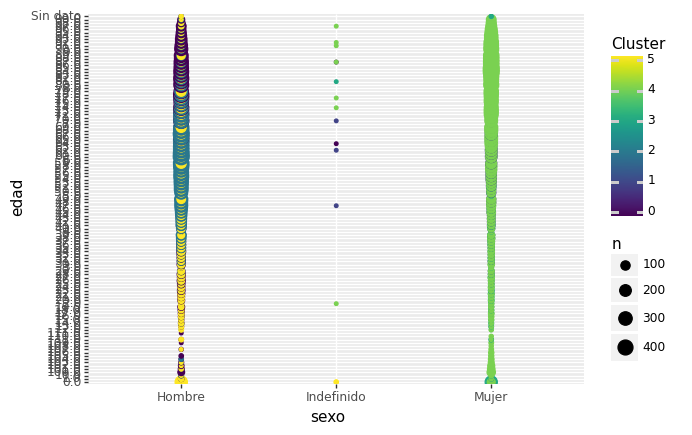

<ggplot: (8779323636825)>

In [ ]:
ggplot(X_train_original) + aes(x="sexo", y="edad", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


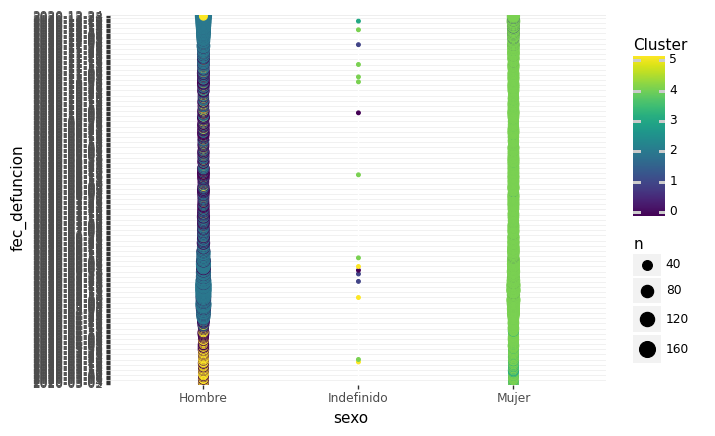

<ggplot: (8779322767905)>

In [ ]:
ggplot(X_train_original) + aes(x="sexo", y="fec_defuncion", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


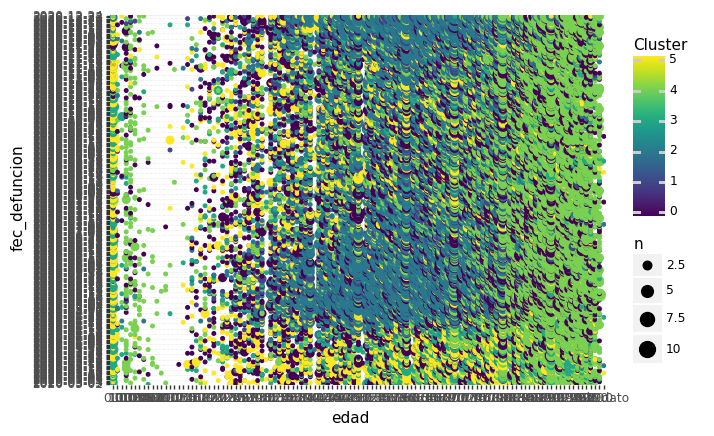

<ggplot: (8779326600505)>

In [ ]:
ggplot(X_train_original) + aes(x="edad", y="fec_defuncion", color="Cluster") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


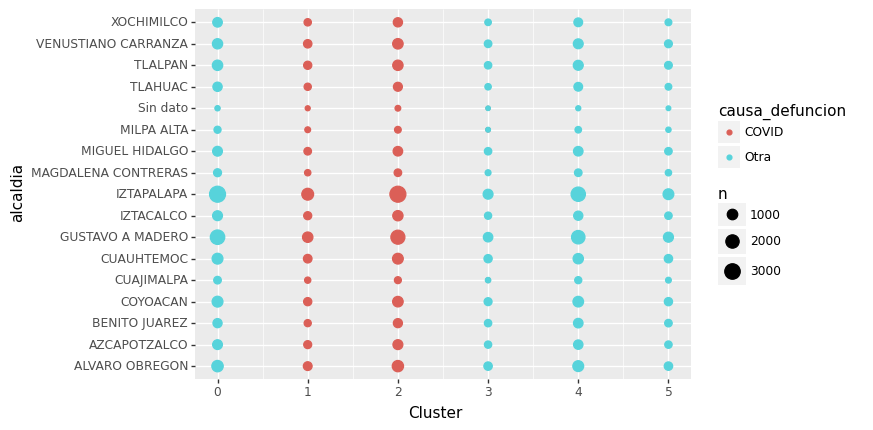

<ggplot: (8779321455597)>

In [ ]:
ggplot(X_train_original) + aes(x="Cluster", y="alcaldia", color="causa_defuncion") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


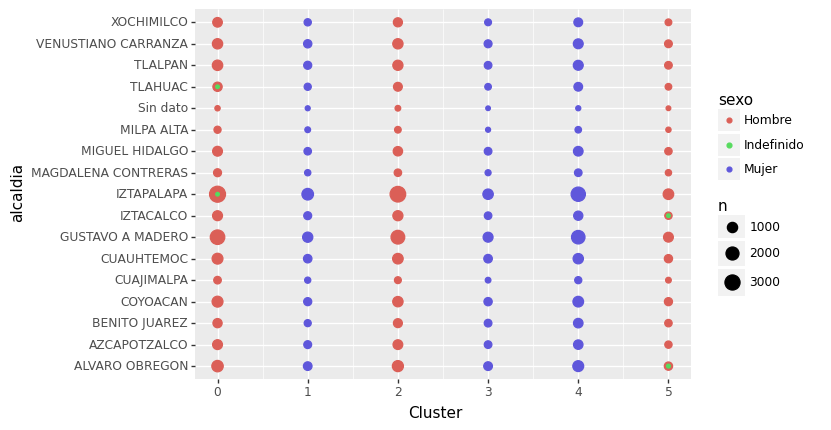

<ggplot: (8779317987245)>

In [ ]:
ggplot(X_train_original) + aes(x="Cluster", y="alcaldia", color="sexo") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


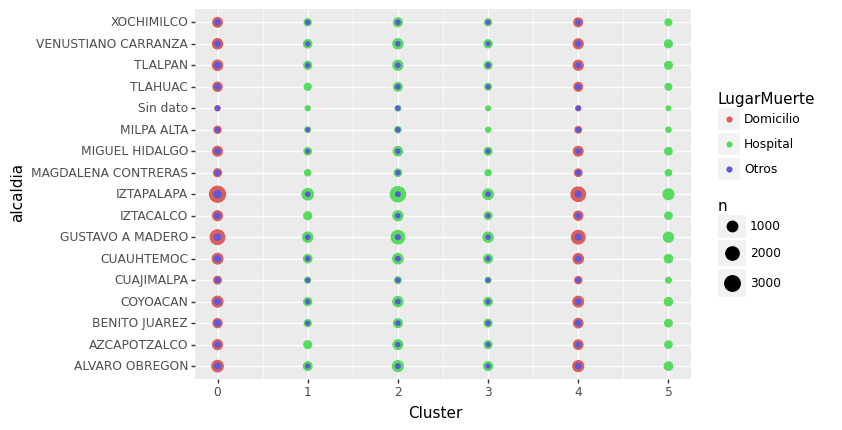

<ggplot: (8779319303153)>

In [ ]:
ggplot(X_train_original) + aes(x="Cluster", y="alcaldia", color="LugarMuerte") + geom_count()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


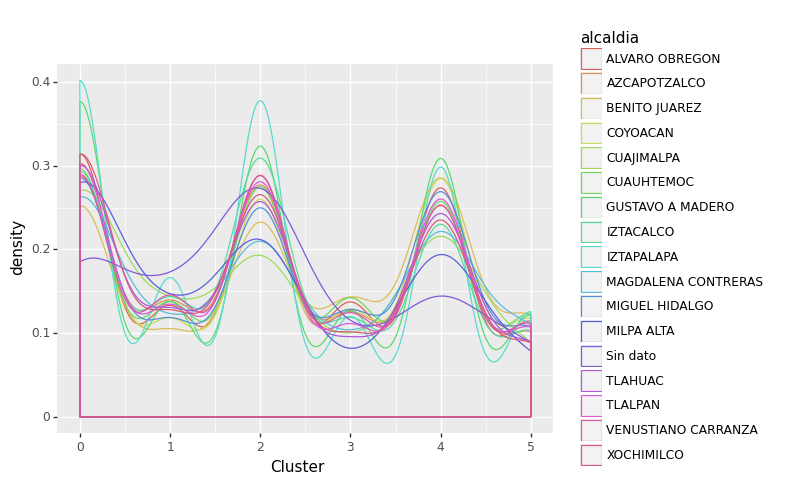

<ggplot: (8779326525941)>

In [ ]:
ggplot(X_train_original) + aes(x="Cluster", color="alcaldia") + geom_density()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 26'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


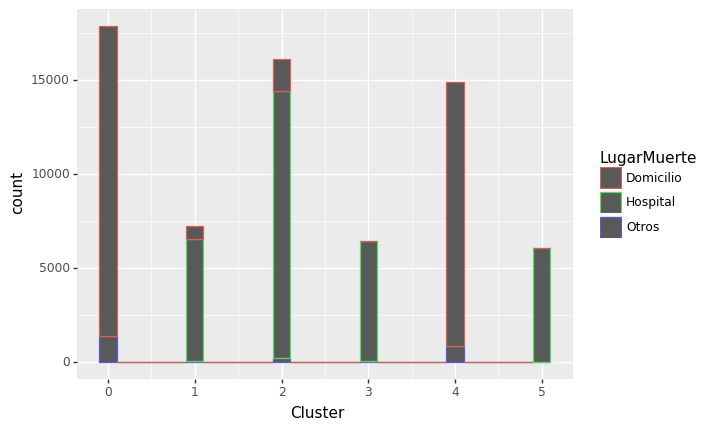

<ggplot: (8779296350901)>

In [ ]:
ggplot(X_train_original) + aes(x="Cluster", color="LugarMuerte") + geom_histogram()

In [ ]:
X_train_cluster_1_2 = X_train_original[X_train_original['Cluster'].isin([1,2])]
X_train_cluster_1_2

,edad,sexo,fec_defuncion,causa,alcaldia,LugarMuerte,causa_defuncion,Cluster
7,64.0,Hombre,2020-05-13,Covid-19 Confirmado o Sospecha,IZTAPALAPA,Hospital,COVID,2
9,67.0,Mujer,2020-07-27,Covid-19 Confirmado o Sospecha,IZTACALCO,Hospital,COVID,1
10,62.0,Hombre,2020-09-27,Covid-19 Confirmado o Sospecha,CUAUHTEMOC,Hospital,COVID,2
13,57.0,Hombre,2020-10-18,Covid-19 Confirmado o Sospecha,AZCAPOTZALCO,Hospital,COVID,2
15,39.0,Hombre,2020-05-04,Covid-19 Confirmado o Sospecha,ALVARO OBREGON,Hospital,COVID,2
...,...,...,...,...,...,...,...,...
68706,45.0,Hombre,2020-12-06,Covid-19 Confirmado o Sospecha,IZTAPALAPA,Hospital,COVID,2
68707,72.0,Hombre,2020-05-19,Covid-19 Confirmado o Sospecha,IZTAPALAPA,Hospital,COVID,2
68712,71.0,Hombre,2020-08-19,Covid-19 Confirmado o Sospecha,XOCHIMILCO,Hospital,COVID,2
68718,70.0,Hombre,2020-10-21,Covid-19 Confirmado o Sospecha,ALVARO OBREGON,Hospital,COVID,2


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 69'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


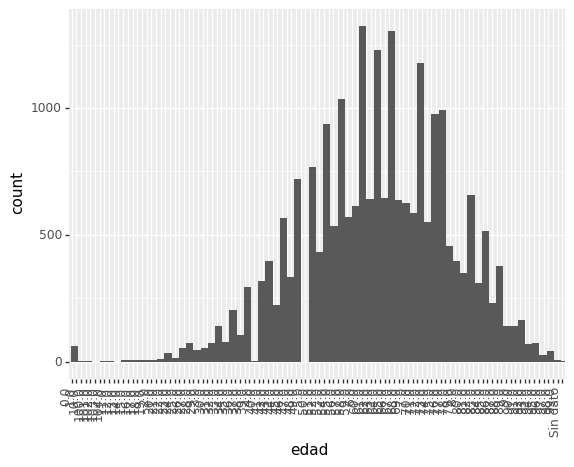

<ggplot: (8779296351365)>

In [ ]:
ggplot(X_train_cluster_1_2) + aes(x="edad") + geom_histogram() + theme(axis_text_x = element_text(angle=90, hjust=1))

In [66]:
from plotnine.geoms import geom_density, geom_jitter